#### LICENSE
These notes are released under the 
"Creative Commons Attribution-ShareAlike 4.0 International" license. 
See the **human-readable version** [here](https://creativecommons.org/licenses/by-sa/4.0/)
and the **real thing** [here](https://creativecommons.org/licenses/by-sa/4.0/legalcode). 

## Ridge regression vs Stepwise via CV

Here we will compare the prediction properties of a model constructed
via stepwise with those of an optimal Ridge Regression one. We will
use CV to estimate the corresponding mean squared prediction errors. 
We also add the full model (without doing any variable selection or
regularization) to the comparison.

In [1]:
airp <- read.table('rutgers-lib-30861_CSV-1.csv', header=TRUE, sep=',')
library(MASS)
library(glmnet)
k <- 5
n <- nrow(airp)
y <- as.vector(airp$MORT)
xm <- as.matrix(airp[, -16])
lambdas <- exp( seq(-3, 10, length=50))

Loading required package: Matrix

Loaded glmnet 4.1-6



We use 5-fold cross-validation to compare the 
MSPE of the 3 models: the **full** model, the one
selected by **stepwise** and the **ridge regression**
one. Note that since the Ridge Regression estimator is
tuned using the training data (we select the penalization parameter 
via CV), we need to run CV within CV here. The same applies
for the stepwise model. 

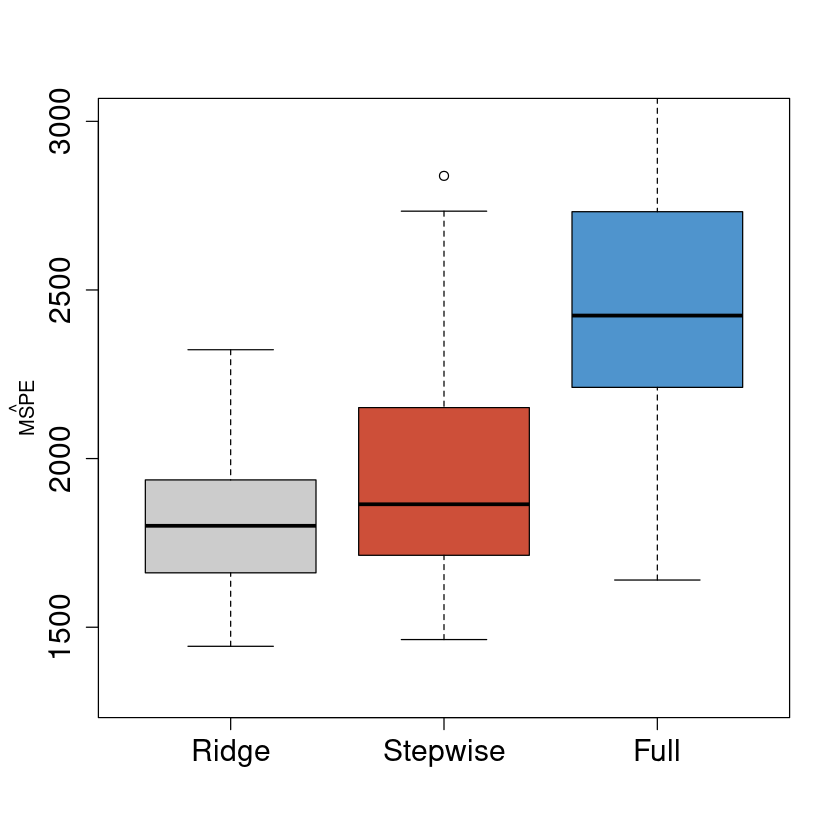

In [2]:
library(MASS)
n <- nrow(xm)
k <- 5
ii <- (1:n) %% k + 1
set.seed(123)
N <- 100
mspe.st <- mspe.ri <- mspe.f <- rep(0, N)
for(i in 1:N) {
  ii <- sample(ii)
  pr.f <- pr.ri <- pr.st <- rep(0, n)
  for(j in 1:k) {
    tmp.ri <- cv.glmnet(x=xm[ii != j, ], y=y[ii != j], lambda=lambdas,
                        nfolds=5, alpha=0, family='gaussian')
    null <- lm(MORT ~ 1, data=airp[ii != j, ])
    full <- lm(MORT ~ ., data=airp[ii != j, ])
    tmp.st <- stepAIC(null, scope=list(lower=null, upper=full), trace=0)
    pr.ri[ ii == j ] <- predict(tmp.ri, s='lambda.min', newx=xm[ii==j,])
    pr.st[ ii == j ] <- predict(tmp.st, newdata=airp[ii==j,])
    pr.f[ ii == j ] <- predict(full, newdata=airp[ii==j,])
  }
  mspe.ri[i] <- mean( (airp$MORT - pr.ri)^2 )
  mspe.st[i] <- mean( (airp$MORT - pr.st)^2 )
  mspe.f[i] <- mean( (airp$MORT - pr.f)^2 )
}
boxplot(mspe.ri, mspe.st, mspe.f, names=c('Ridge', 'Stepwise', 'Full'), 
        col=c('gray80', 'tomato3', 'steelblue3'), cex.axis=1.5, cex.lab=1.5, 
        cex.main=2, ylim=c(1300, 3000))
mtext(expression(hat(MSPE)), side=2, line=2.5)

### An example where one may not need to select variables

In some cases one may not need to select a subset of explanatory
variables, and in fact, doing so may affect negatively the accuracy of
the resulting predictions. In what follows we discuss such an example. 
Consider the credit card data set that contains information
on credit card users. The interest is in predicting the 
balance carried by a client. We first load the data, and to
simplify the presentation here we consider only the numerical
explanatory variables:

In [3]:
x <- read.table('Credit.csv', sep=',', header=TRUE, row.names=1)
x <- x[, c(1:6, 11)]

There are 6 available covariates, and a stepwise search selects 
a model with 5 of them (discarding `Education`):

In [4]:
library(MASS)
null <- lm(Balance ~ 1, data=x)
full <- lm(Balance ~ ., data=x)
(tmp.st <- stepAIC(null, scope=list(lower=null, upper=full), trace=0))


Call:
lm(formula = Balance ~ Rating + Income + Limit + Age + Cards, 
    data = x)

Coefficients:
(Intercept)       Rating       Income        Limit          Age        Cards  
  -449.3610       2.0224      -7.5621       0.1286      -0.8883      11.5527  


It is an easy exercise to check that the MSPE of this
smaller model is in fact worse than the one for the **full** one:

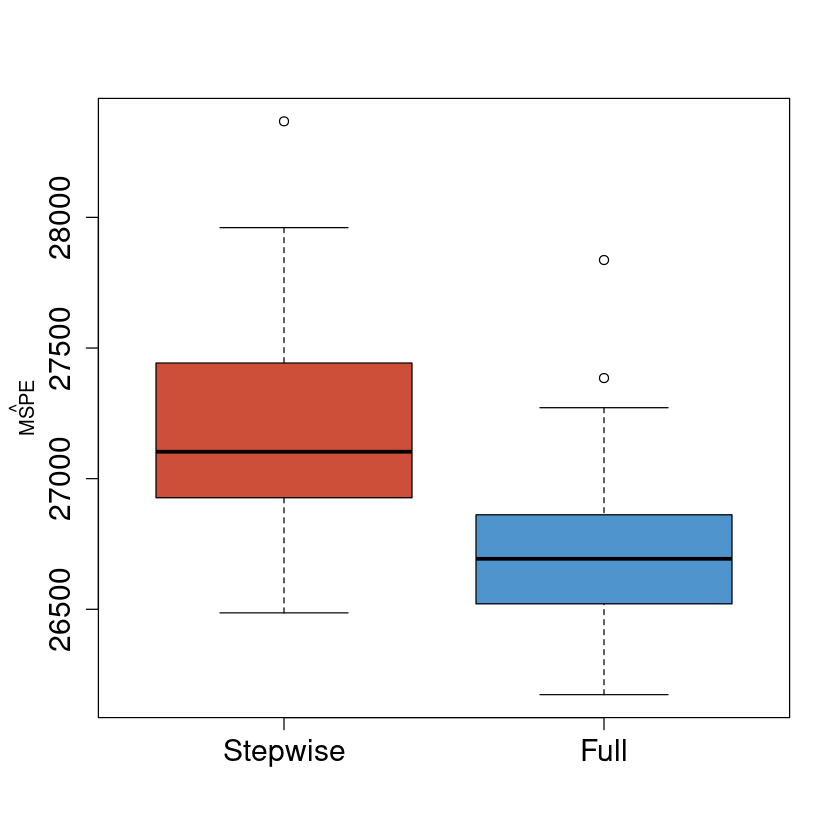

In [5]:
n <- nrow(x)
k <- 5
ii <- (1:n) %% k + 1
set.seed(123)
N <- 100
mspe.st <- mspe.f <- rep(0, N)
for(i in 1:N) {
  ii <- sample(ii)
  pr.f <- pr.st <- rep(0, n)
  for(j in 1:k) {
    null <- lm(Balance ~ 1, data=x[ii != j, ])
    full <- lm(Balance ~ ., data=x[ii != j, ])
    tmp.st <- stepAIC(null, scope=list(lower=null, upper=full), trace=0)
    pr.st[ ii == j ] <- predict(tmp.st, newdata=x[ii==j,])
    pr.f[ ii == j ] <- predict(full, newdata=x[ii==j,])
  }
  mspe.st[i] <- mean( (x$Balance - pr.st)^2 )
  mspe.f[i] <- mean( (x$Balance - pr.f)^2 )
}
boxplot(mspe.st, mspe.f, names=c('Stepwise', 'Full'),
        col=c('tomato3', 'steelblue3'), cex.axis=1.5,
        cex.lab=1.5, cex.main=2)
mtext(expression(hat(MSPE)), side=2, line=2.5)

Using ridge regression instead of stepwise to prevent 
the negative effect of possible correlations among the
covariates yields a slight improvement (over the **full** model), 
but it is not clear the gain is worth the effort.

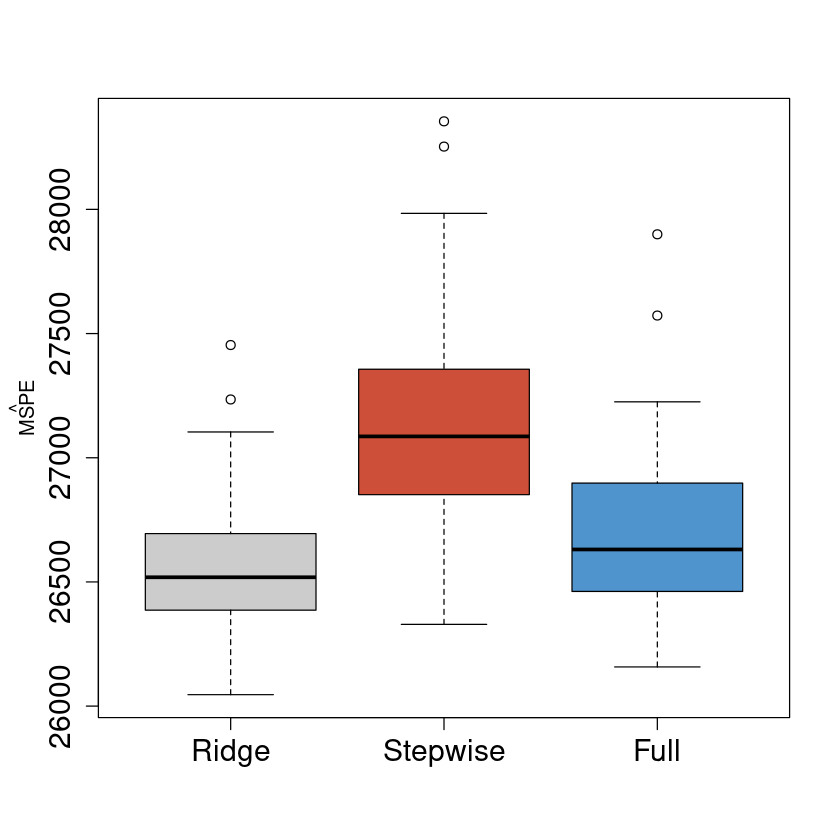

In [6]:
library(glmnet)
y <- as.vector(x$Balance)
xm <- as.matrix(x[, -7])
lambdas <- exp( seq(-3, 10, length=50))
n <- nrow(xm)
k <- 5
ii <- (1:n) %% k + 1
set.seed(123)
N <- 100
mspe.st <- mspe.ri <- mspe.f <- rep(0, N)
for(i in 1:N) {
  ii <- sample(ii)
  pr.f <- pr.ri <- pr.st <- rep(0, n)
  for(j in 1:k) {
    tmp.ri <- cv.glmnet(x=xm[ii != j, ], y=y[ii != j], lambda=lambdas,
                     nfolds=5, alpha=0, family='gaussian')
    null <- lm(Balance ~ 1, data=x[ii != j, ])
    full <- lm(Balance ~ ., data=x[ii != j, ])
    tmp.st <- stepAIC(null, scope=list(lower=null, upper=full), trace=0)
    pr.ri[ ii == j ] <- predict(tmp.ri, s='lambda.min', newx=xm[ii==j,])
    pr.st[ ii == j ] <- predict(tmp.st, newdata=x[ii==j,])
    pr.f[ ii == j ] <- predict(full, newdata=x[ii==j,])
  }
  mspe.ri[i] <- mean( (x$Balance - pr.ri)^2 )
  mspe.st[i] <- mean( (x$Balance - pr.st)^2 )
  mspe.f[i] <- mean( (x$Balance - pr.f)^2 )
}
boxplot(mspe.ri, mspe.st, mspe.f, names=c('Ridge', 'Stepwise', 'Full'), 
        col=c('gray80', 'tomato3', 'steelblue3'), cex.axis=1.5,
        cex.lab=1.5, cex.main=2)
mtext(expression(hat(MSPE)), side=2, line=2.5)